# Reservoir Operations US
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 06-05-2025<br>

**Introduction:**<br>
This notebook expores the dataset ResOpsUS, which contains reservoir operations for dams in the US. The data for reservoirs simulated in GloFAS4.0 are extracted and compared against GloFAS parameters.

**To do:**<br>
* [ ] Compare maximum reservoir storage between GRanD, GloFAS and ResOpsUS.
* [ ] Add GloFAS reservoir limits to the plots

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
# from shapely import Point
import matplotlib.pyplot as plt
# from matplotlib import gridspec
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from datetime import datetime
# import xarray as xr
from tqdm.auto import tqdm
# import yaml

from reservoirs_lshm.utils import DatasetConfig
from reservoirs_lshm.utils.plots import plot_resops, plot_reservoir_map

In [2]:
# path_datasets = Path('Z:/nahaUsers/casadje/datasets/')

### Configuration

In [3]:
cfg = DatasetConfig('config_dataset.yml')

In [4]:
# with open('config_extraction.yml', 'r', encoding='utf8') as ymlfile:
#     cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

# # paths
# PATH_GLOFAS = Path(cfg['paths']['GloFAS'])
# PATH_RESOPS = Path(cfg['paths']['ResOpsUS'])
# PATH_GRAND = Path(cfg['paths']['GRanD'])

## Reservoirs

### ResOpsUS

The ResOpsUS attributes includes 678 reservoirs
The ResOpsUS time series inventory includes 677 reservoirs
ResOpsUS contains 677 reservoirs.
652 of those have storage time series.
320 of those have inflow time series.
517 of those have outflow time series.
311 of those include all those variales.


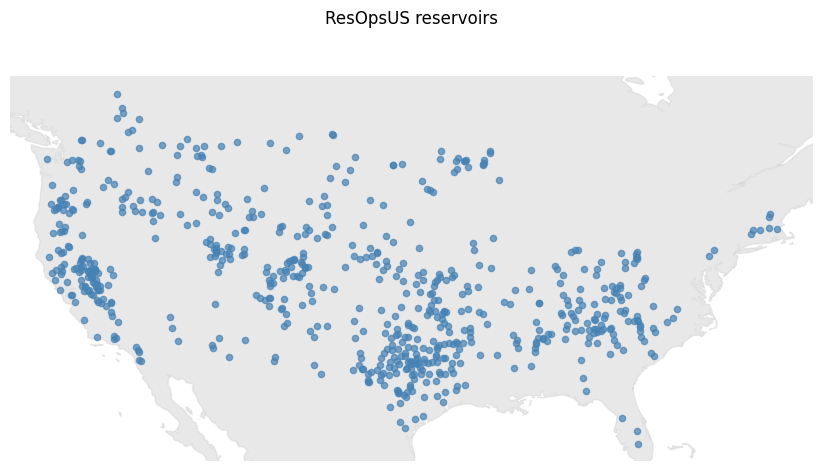

In [10]:
# load reservoir attributes
attributes = pd.read_csv(cfg.PATH_RESOPS / 'raw' / 'attributes' / 'reservoir_attributes.csv', index_col='DAM_ID')
attributes = attributes[~attributes.index.duplicated(keep='first')]
attributes.index.name = 'GRAND_ID'
print(f'The ResOpsUS attributes includes {attributes.shape[0]} reservoirs')

# load time series recorded for each reservoir
inventory = pd.read_csv(cfg.PATH_RESOPS / 'raw' / 'attributes' / 'time_series_inventory.csv', index_col='DAM_ID')
inventory = inventory[~inventory.index.duplicated(keep='first')]
inventory.index.name = 'GRAND_ID'
print(f'The ResOpsUS time series inventory includes {inventory.shape[0]} reservoirs')

# merge attributes and inventory and convert into geopandas
resops = pd.merge(attributes, inventory, left_index=True, right_index=True)
resops = gpd.GeoDataFrame(
    resops,
    geometry=gpd.points_from_xy(resops.LONG, resops.LAT),
    crs='EPSG:4326'
    )

# remove duplicated index
resops = resops[~resops.index.duplicated(keep='first')]

# simplify column names
resops.rename(columns={'AGENCY_CODE': 'AGENCY_COD',
         'TIME_SERIES_START': 'TS_START',
         'TIME_SERIES_END': 'TS_END',
         'INCONSISTENCIES_NOTED': 'NOTES',
         'STORAGE_START': 'STO_START',
         'STORAGE_END': 'STO_END',
         'DATA_SOURCE': 'STO_SOURCE',
         'INFLOW_START': 'IN_START',
         'INFLOW_END': 'IN_END',
         'DATA_SOURCE.1': 'IN_SOURCE',
         'OUTFLOW_START': 'OUT_START',
         'OUTFLOW_END': 'OUT_END',
         'DATA_SOURCE.2': 'OUT_SOURCE', 
         'ELEVATION_START': 'ELE_START', 
         'ELEVATION_END': 'ELE_END',
         'DATA_SOURCE.3': 'ELE_SOURCE',
         'EVAPORATION': 'EVAPORA',
         'EVAPORATION_START': 'EVA_START', 
         'EVAPORATION_END': 'EVA_END',
         'DATA_SOURCE.4': 'EVA_SOURCE'},
                 inplace=True)

# export as shapefile
# path_GIS = cfg.PATH_RESOPS / 'GIS'
# path_GIS.mkdir(exist_ok=True, parent=True)
# resops.to_file(path_GIS / 'reservoirs.shp')

print('ResOpsUS contains {0} reservoirs.'.format(resops.shape[0]))
variables = ['STORAGE', 'INFLOW', 'OUTFLOW']
for var in variables:
    print('{0} of those have {1} time series.'.format((resops[var] == 1).sum(),
                                                      var.lower()))
print('{0} of those include all those variales.'.format(resops[variables].all(axis=1).sum()))

plot_reservoir_map(
    geometry=resops.geometry,
    save=None,
    title='ResOpsUS reservoirs',
    size=20
)

### GRanD

GRanD contains 677 out of 677 reservoirs in ResOpsUS.


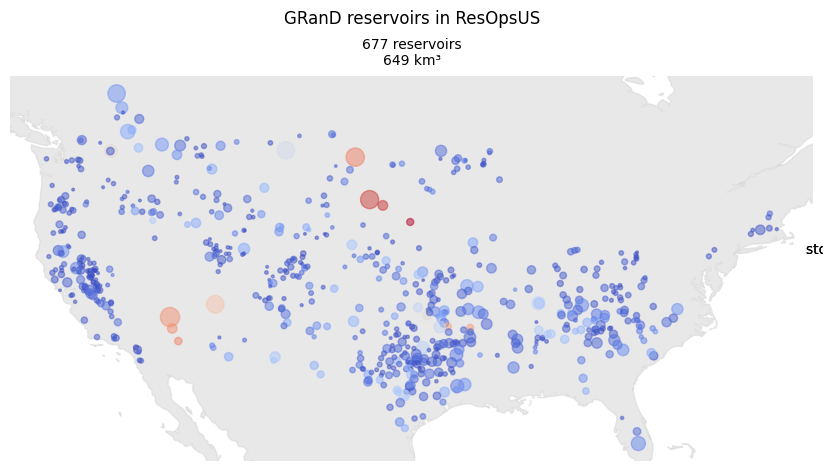

In [13]:
# import data set
grand = gpd.read_file(cfg.PATH_GRAND / 'grand_dams_v1_3.shp')
grand.set_index('GRAND_ID', drop=True, inplace=True)
grand = grand.replace(-99, np.nan)

# keep only reservoirs in ResOpsUS
mask = resops.index.intersection(grand.index)
grand = grand.loc[mask]

print('GRanD contains {0} out of {1} reservoirs in ResOpsUS.'.format(grand.shape[0], resops.shape[0]))

plot_reservoir_map(
    geometry=grand.geometry, 
    volume=grand.CAP_MCM, 
    area=grand.CATCH_SKM,
    save=None,
    title='GRanD reservoirs in ResOpsUS',
    alpha=.5,
)

## GloFAS

In [17]:
# load GloFAS reservoirs
glofas = gpd.read_file(cfg.PATH_LISFLOOD / 'tables' / 'GloFAS_reservoirs.shp')
glofas.GRAND_ID = glofas.GRAND_ID.astype(pd.Int64Dtype())
glofas.GLWD_ID = glofas.GLWD_ID.astype(pd.Int64Dtype())
glofas.set_index('GRAND_ID', inplace=True)

# keep only reservoirs in ResOpsUS
mask = glofas.index.intersection(resops.index)
glofas = glofas.loc[mask]

# remove duplicates
glofas = glofas[~glofas.index.duplicated(keep='first')]

glofas.sort_index(axis=0, inplace=True)

There are two reservoirs that are duplicated in GloFAS:
* The reservoir with GRanD_ID 993 (Lake of the Ozarks) has both ResID 361 and 362.
* The reservoir with GranD_ID 1752 (Kentucky Lake) has both ResID 385 and 386.

In both cases, the attributes are all the same but the LISFLOOD outflow paramters: _minq_, _ndq_, _normq_.

GloFAS contains 121 out of 677 reservoirs in ResOpsUS.


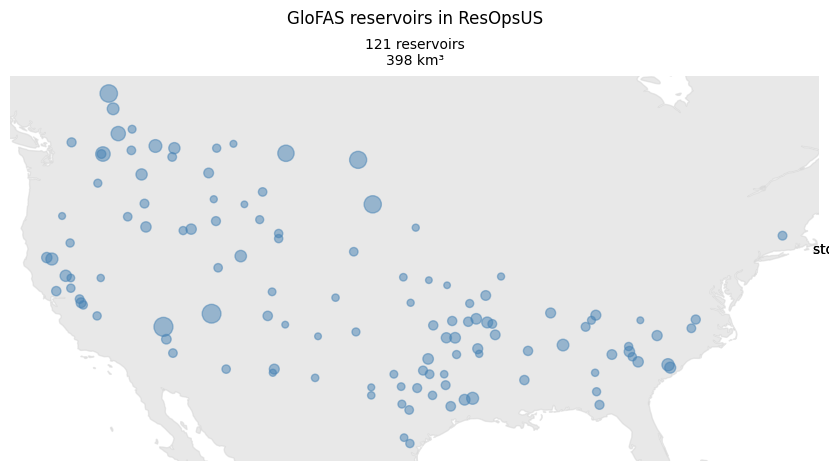

In [20]:
print('GloFAS contains {0} out of {1} reservoirs in ResOpsUS.'.format(glofas.shape[0], resops.shape[0]))

plot_reservoir_map(
    geometry=glofas.geometry,
    volume=glofas.stor,
    save=None,
    title='GloFAS reservoirs in ResOpsUS',
    alpha=.5
)

***

**Compare the reservoir capacity in GloFAS and GRanD**

In [15]:
# DataFrame of reservoir capacity in both datasets
capacity = pd.concat((glofas.stor, grand.CAP_MCM), axis=1, join='inner')
capacity.columns = ['GloFAS', 'GRanD']

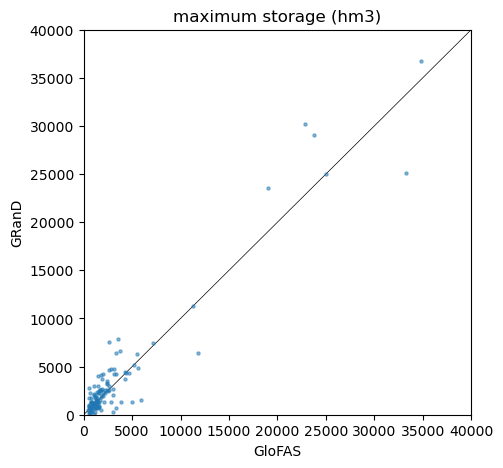

In [16]:
# scatter plot
r = 1e4
cmin = np.floor(capacity.min().min() / r) * r
cmax = np.ceil(capacity.max().max() / r) * r

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(capacity.GloFAS, capacity.GRanD, s=5, alpha=.5)
ax.plot([cmin, cmax], [cmin, cmax], lw=.5, c='k', zorder=0)
ax.set(xlim=(cmin, cmax),
       xlabel='GloFAS',
       ylim=(cmin, cmax),
       ylabel='GRanD',
       title='maximum storage (hm3)');
# ax.set_aspect('equal')

Surprisingly, there's considerable dispersion between the reservoir capacity in both datasets. 

## Time series

In [48]:
series = {}
for ID in tqdm(glofas.index):
    # load timeseries
    series_id = pd.read_csv(PATH_RESOPS / 'raw' / 'time_series_all' / f'ResOpsUS_{ID}.csv', parse_dates=True, index_col='date')
    series_id.columns.name = 'variable'
    # remove empty time series
    # series_id.dropna(axis=1, how='all', inplace=True)
    # remove duplicated index
    series_id = series_id[~series_id.index.duplicated(keep='first')]
    # organize in a DataFrame by variable
    series[ID] = series_id

  0%|          | 0/121 [00:00<?, ?it/s]

In [ ]:
path_out = Path('./ResOps')
path_out.mkdir(parents=True, exist_ok=True)

for ID, df in series.items():
    title = '{0} - {1} ({2})'.format(ID, *resops.loc[ID, ['DAM_NAME', 'STATE']])
    plot_resops(
        df.storage, 
        df.elevation, 
        df.inflow, 
        df.outflow, 
        capacity=capacity.loc[ID].to_list(),
        xlim=(datetime(1979, 1, 1), None), 
        title=title, 
        # save=path_out / f'{ID:04}.jpg'
    )

Hoover, Glen Canyon, Fort Peck, Toledo Bend, Structure 193, Wesley E. Seale, Coolidge

The inspection of the previous plots shows that the maximum storage capacity in neither GloFAS nor GRanD are fully reliable. In some cases there are big difference between the capacity reported by GRanD and GloFAS, and depending on the reservoir, the incorrect value is one of these datasets or the other. I consider erroneous the capacity value when there's a clear offset compared with the storage time series.

In [ ]:
# reservoirs selected in Otta et al. (2023)
dams = ['Hoover', 'Glen Canyon', 'Fort Peck Dam', 'Toledo Bend', 'Structure 193', 'Wesley E. Seale Dam', 'Coolidge']
mask_dams = grand.DAM_NAME.isin(dams)
grand_IDs = grand.loc[mask_dams].index.to_list()

grand_IDs

In [ ]:
capacity.loc[[307, 597, 610, 656, 1269, 1317]]

The reservoir named Structure 193 (GRanD ID 1957) is not modelled in GloFAS. From the other 6 reservoirs:

* 307 - Fort Deck. The GloFAS capacity (19,000 hm3) is slightly below the peaks in the storage time series. The capacity in GRanD (23,560 hm3) seems correct.
* 597 - Glen Canyon. The GloFAS capacity (33,300 hm3) seems accurate. The GRanD value (25,070 hm3) might be an error in the units (Wikipedia says that the capacity is 25000 acre·ft or 31,000 hm3).
* 610 - Hoover. Both values are similar and could be correct.
* 656 - Coolidge. Similar values, but both are well above the time series.
* 1269 - Toledo Bend. The GloFAS capacity (5,520 hm3) is below the storage time series. The GRanD value (6287.7 hm3) seems correct.
* 1317 - Wesley E. Seale. The GloFAS value (1240 hm3) is double as that of GRanD (655 hm3), and both are well above the storage time series. According to a website from the Texas Government, the volume of the reservoir is 314.2 hm3, which can be closer to the storage time series.

In [ ]:
for ID, df in series.items():
    cap_glofas, cap_grand = capacity.loc[ID]
    if cap_glofas < df.storage.max():
        print('{0} - Glofas: {1:.1f} hm3\tseries: {2:.1f} hm3'.format(ID, cap_glofas, df.storage.max()))